# Curriculum Learning - Late Game First

Train agent on partial board states from known solutions for April 14.
Start with 2 pieces remaining (i.e. place the second-to-last piece on a winnable board), progress to 7 pieces remaining (place the second piece).

Episode structure: agent sees board with N-M pieces placed, chooses 1 action, gets reward based on whether it's in valid solution set.

In the easiest level, there are < 10ish possible moves, and many will be a winning move.
On the hardest level, there are hundreds of possible moves, and most will brick the game. There are about 50 solutions for April 14. Some moves are a part of many solutions (2412 -- Z piece in the top right corner is in 35 out of the 47) while some are only a part of one solution (e.g. 55 -- K "knee" piece horizontal on the second row).

In [1]:
from sb3_contrib import MaskablePPO
from stable_baselines3.common.vec_env import SubprocVecEnv
from torch.distributions import Distribution

from apad_puzzle_rl.training_utils import (
    GradNormCallback,
    TimerCallback,
    make_curriculum_env,
)

# Disable validation to avoid Simplex constraint issues
Distribution.set_default_validate_args(False)

# Evaluation Functions

In [214]:
import numpy as np

from apad_puzzle_rl.envs.apad_env import APADEnv
from apad_puzzle_rl.envs.curriculum_env import CurriculumAPADEnv

In [249]:
# Place a single piece -- correct or blunder?
def evaluate(model, pieces_remaining, deterministic=True):
    env = CurriculumAPADEnv(4, 14, pieces_remaining)
    obs, info = env.reset()
    actions = []
    action, _ = model.predict(obs, action_masks=info["action_mask"], deterministic=deterministic)
    actions.append(action)
    obs, reward, terminated, truncated, info = env.step(action)
    env.visualize()
    print("action:", *actions)
    print("n pieces remaining:", env.pieces_remaining)
    print("action space size:", np.count_nonzero(info["action_mask"]))
    if reward:
        print("correct move")
    else:
        print("!! Blunder !!")
    if truncated:
        obs, info = env.reset()
        actions.clear()

In [179]:
# Place a single piece for n_episodes situations, evaluate success rate
def evaluate_curriculum_agent(model, pieces_remaining=2, n_episodes=100):
    """Evaluate agent at specific curriculum level with deterministic policy."""
    agent_success = 0
    random_success = 0

    for _ in range(n_episodes):
        # Agent episode
        test_env = CurriculumAPADEnv(4, 14, pieces_remaining=pieces_remaining)
        obs, info = test_env.reset()

        action_masks = info["action_mask"]
        action, _ = model.predict(obs, action_masks=action_masks, deterministic=True)
        obs, reward, terminated, truncated, info = test_env.step(action)

        agent_success += reward > 0.5

        # Random baseline
        random_env = CurriculumAPADEnv(4, 14, pieces_remaining=pieces_remaining)
        obs, info = random_env.reset()

        valid_actions = np.where(info["action_mask"])[0]
        if len(valid_actions) > 0:
            action = np.random.choice(valid_actions)
            obs, reward, terminated, truncated, info = random_env.step(action)
            random_success += reward > 0.5

    agent_rate = agent_success / n_episodes
    random_rate = random_success / n_episodes

    return {
        "success_rate": agent_rate,
        "random_baseline": random_rate,
        "advantage": agent_rate - random_rate,
    }

In [305]:
# Play until we get a win on April 14
# Don't win with deterministic=True!
def play_until_win(model, deterministic=False, visualize=False):
    mean_step_count = 0

    env = APADEnv(4, 14)
    obs, info = env.reset()
    step_count = 0
    attempt_count = 0
    print_interval = 500.0

    while step_count < 8:
        attempt_count += 1
        if attempt_count % print_interval == 0:
            print(step_count, round(mean_step_count, 3))

        obs, info = env.reset()
        done = False
        step_count = 0

        while not done:
            action, _ = model.predict(
                obs, deterministic=deterministic, action_masks=info["action_mask"]
            )
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            step_count += 1
            if done:
                mean_step_count = (mean_step_count + step_count) / 2.0

        if terminated:
            break

    if visualize:
        env.visualize()

    return attempt_count

In [492]:
# how often do we win a complete game?
def evaluate_win_rate(model, month, day, n_episodes=1000):
    """Evaluate model win rate on complete games."""
    env = APADEnv(month, day)
    wins = 0

    for i in range(n_episodes):
        obs, info = env.reset()
        done = False

        while not done:
            action, _ = model.predict(obs, deterministic=False, action_masks=info["action_mask"])
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

        wins += terminated

    wins += 0.00001

    return wins / n_episodes

In [494]:
# given a 4/14 partial board, complete the game.
# return number of pieces remaining and success bool
def finish_game(model, pieces_remaining, deterministic, visualize):
    """Start from partial board state, play to completion.

    Args:
        model: Trained model
        pieces_remaining: Starting difficulty (how many pieces left to place)
        deterministic: Use deterministic policy
        visualize: Show final board state

    Returns:
        (pieces_left, success): Final pieces remaining and whether game was won
    """
    # Get partial board from curriculum env
    env = CurriculumAPADEnv(4, 14, pieces_remaining=pieces_remaining)
    obs, info = env.reset()

    # Play until done, using parent class step to avoid 1-step termination
    done = False
    while not done:
        action, _ = model.predict(
            obs, action_masks=info["action_mask"], deterministic=deterministic
        )
        # Call parent class step method to bypass 1-step termination
        obs, reward, terminated, truncated, info = APADEnv.step(env, action)
        done = terminated or truncated

    # Count remaining pieces
    final_pieces_remaining = np.sum(env.remaining_pieces)
    success = terminated  # True if won, False if truncated

    if visualize:
        env.visualize()
        print(f"Pieces remaining: {final_pieces_remaining}")
        print(f"Success: {success}")

    return final_pieces_remaining, success

# Level 2 (2 pieces remaining)

## Train

In [5]:
# Level 2: 2 pieces remaining
n_envs = 6
pieces_remaining = 2

env = SubprocVecEnv(
    [lambda: make_curriculum_env(pieces_remaining=pieces_remaining) for _ in range(n_envs)]
)

model = MaskablePPO(
    "MlpPolicy",
    env,
    tensorboard_log="./curriculum_ppo_logs_manual/",
    verbose=1,
    batch_size=256,
    n_steps=256,
    ent_coef=0.001,
    learning_rate=3e-3,
)

model.learn(
    total_timesteps=200_000,
    reset_num_timesteps=True,
    callback=[TimerCallback(), GradNormCallback()],
)

model.save(f"curriculum_model_lvl{pieces_remaining}")

Using cpu device
Logging to ./curriculum_ppo_logs_manual/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.52     |
| time/              |          |
|    fps             | 1307     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 1536     |
| train/             |          |
|    grad_norm       | 0        |
---------------------------------
Step 3000, 3s elapsed, 182s remaining
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1          |
|    ep_rew_mean          | 0.67       |
| time/                   |            |
|    fps                  | 1087       |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 3072       |
| train/                  |            |
|    approx_kl            | 0.08485194 |
|    clip_fraction        | 0.637      |

## Evaluate

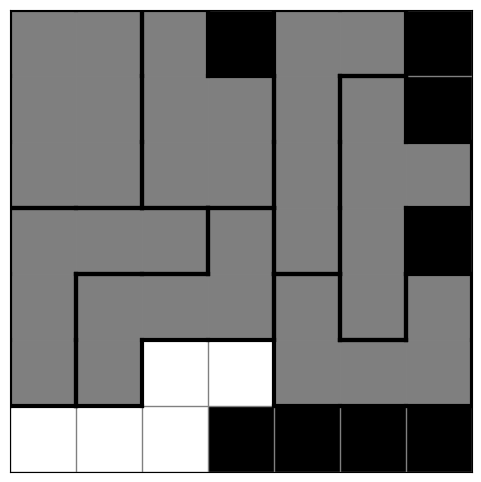

action: 1376
n pieces remaining: 2
action space size: 1
correct move


In [180]:
evaluate(model, pieces_remaining)

In [181]:
# Evaluate level 2
results = evaluate_curriculum_agent(model, pieces_remaining=pieces_remaining, n_episodes=1000)
print("2 pieces remaining")
print(f"  Agent success:  {results['success_rate']:.1%}")
print(f"  Random baseline: {results['random_baseline']:.1%}")
print(f"  Advantage:      {results['advantage']:+.1%}")

2 pieces remaining
  Agent success:  98.5%
  Random baseline: 59.4%
  Advantage:      +39.1%


Just curious how does the level 2 agent perform on higher levels?

In [182]:
results = evaluate_curriculum_agent(model, pieces_remaining=3, n_episodes=1000)
print("3 pieces remaining")
print(f"  Agent success:  {results['success_rate']:.1%}")
print(f"  Random baseline: {results['random_baseline']:.1%}")
print(f"  Advantage:      {results['advantage']:+.1%}")

3 pieces remaining
  Agent success:  80.1%
  Random baseline: 28.5%
  Advantage:      +51.6%


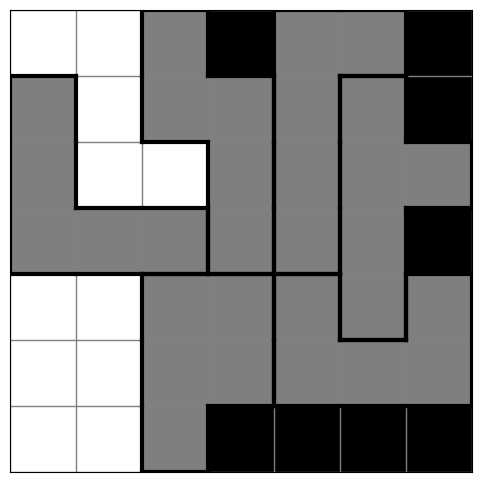

action: 1039
n pieces remaining: 3
action space size: 2
correct move


In [188]:
evaluate(model, 3)

In [199]:
results = evaluate_curriculum_agent(model, pieces_remaining=4, n_episodes=1000)
print("4 pieces remaining")
print(f"  Agent success:  {results['success_rate']:.1%}")
print(f"  Random baseline: {results['random_baseline']:.1%}")
print(f"  Advantage:      {results['advantage']:+.1%}")

4 pieces remaining
  Agent success:  57.2%
  Random baseline: 11.2%
  Advantage:      +46.0%


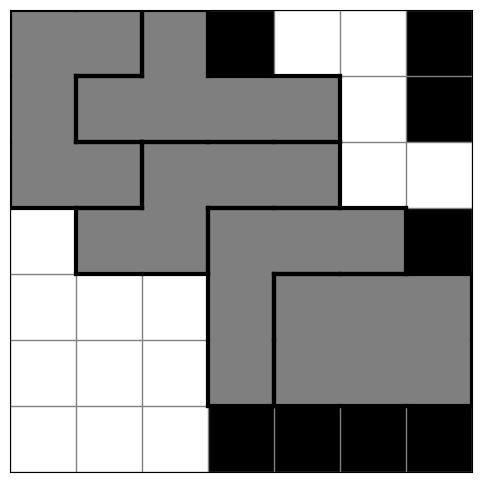

action: 216
n pieces remaining: 4
action space size: 24
correct move


In [197]:
evaluate(model, 4)

# Level 3

## Train

In [200]:
# Level 3: 3 pieces remaining
n_envs = 6
pieces_remaining = 3

# Create new environments for level 3
env = SubprocVecEnv(
    [lambda: make_curriculum_env(pieces_remaining=pieces_remaining) for _ in range(n_envs)]
)

# Load level 2 model and continue training on level 3
model = MaskablePPO.load("curriculum_model_lvl2")
model.set_env(env)  # Important: tell model about new environment

model.learn(
    total_timesteps=200_000,
    reset_num_timesteps=False,
    callback=[TimerCallback(), GradNormCallback()],
)

model.save(f"curriculum_model_lvl{pieces_remaining}")

Logging to ./curriculum_ppo_logs_manual/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.82     |
| time/              |          |
|    fps             | 1098     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 202752   |
| train/             |          |
|    grad_norm       | 0        |
---------------------------------
Step 204000, 3s elapsed, 3s remaining
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1          |
|    ep_rew_mean          | 0.81       |
| time/                   |            |
|    fps                  | 898        |
|    iterations           | 2          |
|    time_elapsed         | 3          |
|    total_timesteps      | 204288     |
| train/                  |            |
|    approx_kl            | 0.19500844 |
|    clip_fraction        | 0.244      |
|    clip_range 

## Evaluation

In [203]:
# Evaluate level 3
results = evaluate_curriculum_agent(model, pieces_remaining=pieces_remaining, n_episodes=1000)
print(f"{pieces_remaining} pieces remaining")
print(f"  Agent success:  {results['success_rate']:.1%}")
print(f"  Random baseline: {results['random_baseline']:.1%}")
print(f"  Advantage:      {results['advantage']:+.1%}")

3 pieces remaining
  Agent success:  97.6%
  Random baseline: 27.8%
  Advantage:      +69.8%


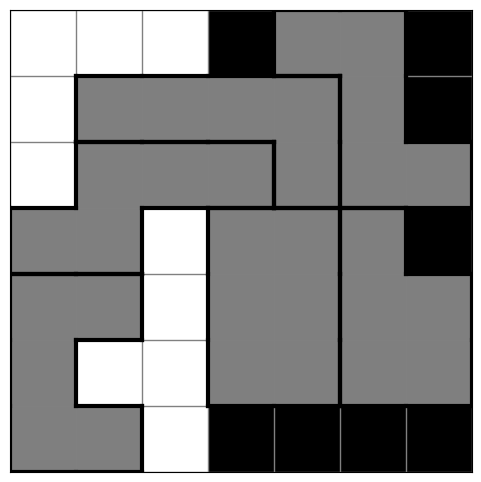

action: 2412
n pieces remaining: 3
action space size: 3
correct move


In [283]:
# deterministic doesn't seem to matter too much
evaluate(model, 3, deterministic=False)

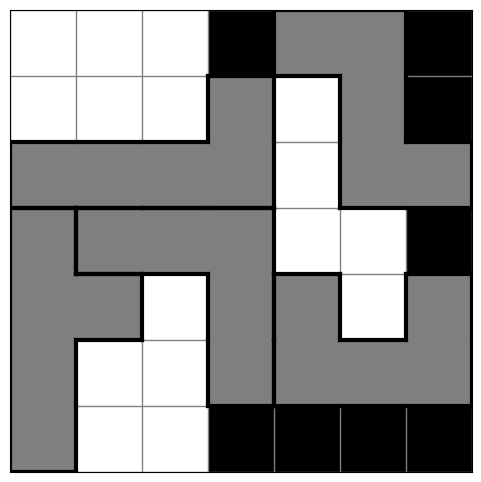

action: 2286
n pieces remaining: 4
action space size: 7
correct move


In [282]:
# deterministic doesn't seem to matter too much
evaluate(model, 4, deterministic=False)

#### full game tests

- mean(1/\# of tests required to win)
- mean(win rate)

In [310]:
# How many attempts required to win 4/14?
attempts = play_until_win(model, deterministic=False, visualize=False)
print(f"Solution found after {attempts} attempts.")

Solution found after 9 attempts.


In [316]:
# Statistically, the average of the reciprocal

# Test on April 14 (trained date)
print("April 14 (trained):")
win_rate_414 = evaluate_win_rate(model, 4, 14, n_episodes=10000)
print(f"Win rate: {win_rate_414:.1%}\n")

# Test on April 15 (generalization)
print("April 15 (unseen):")
win_rate_415 = evaluate_win_rate(model, 4, 15, n_episodes=100)
print(f"Win rate: {win_rate_415:.1%}")

April 14 (trained):
Win rate: 3.2%

April 15 (unseen):
Win rate: 0.0%


In [318]:
# same as the above (4/14)
n_episodes = 200
mean_attempts = 0
for i in range(n_episodes):
    if i % 10 == 0:
        print(i)
    mean_attempts += play_until_win(model, deterministic=False, visualize=False)
mean_attempts /= n_episodes
x = 1 / mean_attempts
print(x)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0.030959752321981428


In [315]:
# Statistically, the reciprocal of the average

n_episodes = 100
rate = 0
for i in range(n_episodes):
    if i % 10 == 0:
        print(i)
    rate += 1.0 / play_until_win(model, deterministic=False, visualize=False)
rate /= n_episodes
print(rate)

0
10
20
30
40
50
60
70
80
90
April 14 win rate: 0.14230710066811528


Expected difference between first and second goes like variation in the rate/rate^3

$E[1/X] - 1/μ ≈ Var(X)/μ³ = 0.11$

$1/μ = 0.032$

$μ = 31.2$

$Var(X) = .11 * 31.2^3 = 3340.8 \rightarrow \sqrt Var(X) = \sigma = 58$

big spread

# Level 4

## Train

In [321]:
# Level 3: 3 pieces remaining
n_envs = 6
pieces_remaining = 4

# Create new environments for level 4
env = SubprocVecEnv(
    [lambda: make_curriculum_env(pieces_remaining=pieces_remaining) for _ in range(n_envs)]
)

# Load level 3 model and continue training on level 4
model = MaskablePPO.load("curriculum_model_lvl3")
model.set_env(env)  # Important: tell model about new environment

model.learn(
    total_timesteps=400_000,
    reset_num_timesteps=False,
    callback=[TimerCallback(), GradNormCallback()],
)

model.save(f"curriculum_model_lvl{pieces_remaining}")

Logging to ./curriculum_ppo_logs_manual/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.84     |
| time/              |          |
|    fps             | 1045     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 403968   |
| train/             |          |
|    grad_norm       | 0        |
---------------------------------
Step 405000, 3s elapsed, 3s remaining
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1         |
|    ep_rew_mean          | 0.91      |
| time/                   |           |
|    fps                  | 802       |
|    iterations           | 2         |
|    time_elapsed         | 3         |
|    total_timesteps      | 405504    |
| train/                  |           |
|    approx_kl            | 0.2703307 |
|    clip_fraction        | 0.224     |
|    clip_range           | 

## Eval

In [352]:
# Evaluate level 4
# Just the ability to place the fifth piece
results = evaluate_curriculum_agent(model, pieces_remaining=pieces_remaining, n_episodes=1000)
print(f"{pieces_remaining} pieces remaining")
print(f"  Agent success:  {results['success_rate']:.1%}")
print(f"  Random baseline: {results['random_baseline']:.1%}")
print(f"  Advantage:      {results['advantage']:+.1%}")

4 pieces remaining
  Agent success:  97.4%
  Random baseline: 11.9%
  Advantage:      +85.5%


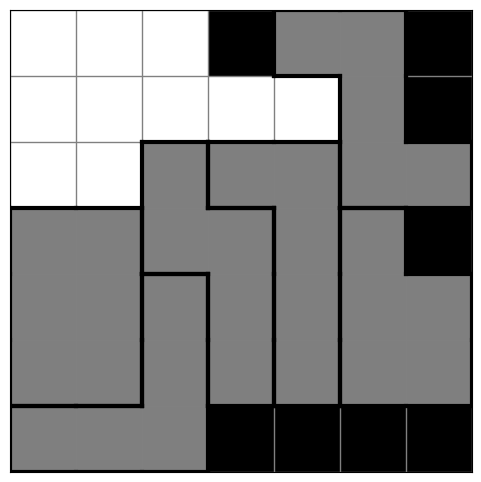

action: 2412
n pieces remaining: 3
action space size: 8
correct move


In [349]:
# deterministic doesn't seem to matter too much
evaluate(model, pieces_remaining, deterministic=False)

In [350]:
# Evaluate level 5
results = evaluate_curriculum_agent(model, pieces_remaining=5, n_episodes=1000)
print(f"{pieces_remaining} pieces remaining")
print(f"  Agent success:  {results['success_rate']:.1%}")
print(f"  Random baseline: {results['random_baseline']:.1%}")
print(f"  Advantage:      {results['advantage']:+.1%}")

4 pieces remaining
  Agent success:  87.8%
  Random baseline: 5.8%
  Advantage:      +82.0%


In [351]:
# Test on April 14 (trained date)
print("April 14 (trained):")
win_rate_414 = evaluate_win_rate(model, 4, 14, n_episodes=5000)
print(f"Win rate: {win_rate_414:.1%}\n")

April 14 (trained):
Win rate: 29.6%



# Level 5 (5 pieces remaining, 3 pieces currently on the board)

## Train

In [526]:
# Level 5: 5 pieces remaining
n_envs = 6
pieces_remaining = 5

env = SubprocVecEnv(
    [
        lambda: make_curriculum_env(pieces_remaining=pieces_remaining, replay_prob=0.2)
        for _ in range(n_envs)
    ]
)

model = MaskablePPO.load("curriculum_model_lvl4")
model.learning_rate = 1e-3
model.set_env(env)

model.learn(
    total_timesteps=1_000_000,
    reset_num_timesteps=False,  # Continue from lvl4 timesteps
    callback=[TimerCallback(), GradNormCallback()],
)

model.save(f"curriculum_model_lvl{pieces_remaining}")

Logging to ./curriculum_ppo_logs_manual/PPO_1
Step 804000, 1s elapsed, 1s remaining
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.92     |
| time/              |          |
|    fps             | 962      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 804864   |
| train/             |          |
|    grad_norm       | 0        |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1          |
|    ep_rew_mean          | 0.85       |
| time/                   |            |
|    fps                  | 798        |
|    iterations           | 2          |
|    time_elapsed         | 3          |
|    total_timesteps      | 806400     |
| train/                  |            |
|    approx_kl            | 0.25501046 |
|    clip_fraction        | 0.149      |
|    clip_range 

## Evaluation

In [527]:
# Evaluate level 5
# Just the ability to place the fifth piece
model = MaskablePPO.load("curriculum_model_lvl5")
results = evaluate_curriculum_agent(model, pieces_remaining=pieces_remaining, n_episodes=1000)
print(f"{pieces_remaining} pieces remaining")
print(f"  Agent success:  {results['success_rate']:.1%}")
print(f"  Random baseline: {results['random_baseline']:.1%}")
print(f"  Advantage:      {results['advantage']:+.1%}")

5 pieces remaining
  Agent success:  96.2%
  Random baseline: 4.1%
  Advantage:      +92.1%


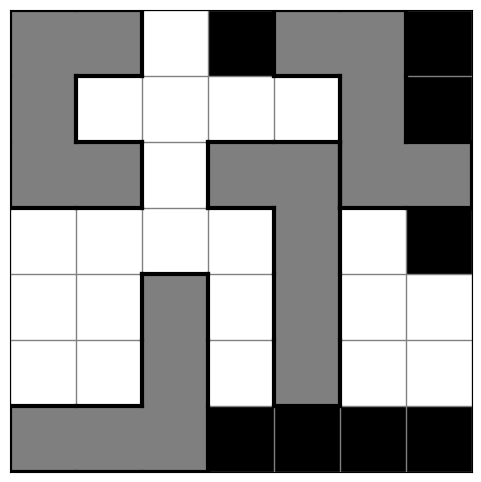

action: 2412
n pieces remaining: 5
action space size: 18
correct move


In [532]:
# deterministic doesn't seem to matter too much
evaluate(model, pieces_remaining, deterministic=False)

In [533]:
# Evaluate level 6
results = evaluate_curriculum_agent(model, pieces_remaining=6, n_episodes=1000)
print(f"{6} pieces remaining")
print(f"  Agent success:  {results['success_rate']:.1%}")
print(f"  Random baseline: {results['random_baseline']:.1%}")
print(f"  Advantage:      {results['advantage']:+.1%}")

6 pieces remaining
  Agent success:  87.1%
  Random baseline: 2.9%
  Advantage:      +84.2%


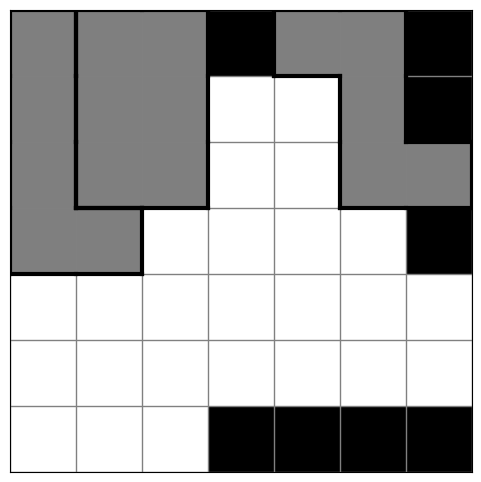

action: 2412
n pieces remaining: 6
action space size: 240
correct move


In [491]:
# deterministic doesn't seem to matter too much
evaluate(model, 6, deterministic=False)

In [372]:
# Test on April 14 (trained date)
print("April 14 (trained):")
win_rate_414 = evaluate_win_rate(model, 4, 14, n_episodes=5000)
print(f"Win rate: {win_rate_414:.1%}\n")

April 14 (trained):
Win rate: 8.4%



In [495]:
model = MaskablePPO.load("curriculum_model_lvl5")

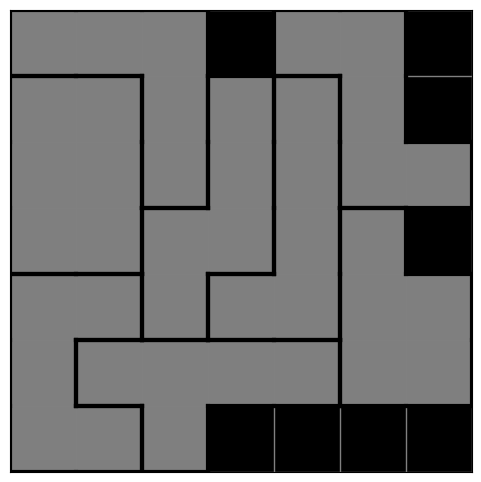

Pieces remaining: 0
Success: True


In [520]:
n_piece_remaining, success = finish_game(
    model, pieces_remaining=2, deterministic=True, visualize=True
)

# Level 6

## Train

In [534]:
n_envs = 6
pieces_remaining = 6

env = SubprocVecEnv(
    [
        lambda: make_curriculum_env(pieces_remaining=pieces_remaining, replay_prob=0.2)
        for _ in range(n_envs)
    ]
)

model = MaskablePPO.load("curriculum_model_lvl5")
model.learning_rate = 5e-4
model.set_env(env)

model.learn(
    total_timesteps=1_000_000,
    reset_num_timesteps=False,  # Continue from lvl4 timesteps
    callback=[TimerCallback(), GradNormCallback()],
)

model.save(f"curriculum_model_lvl{pieces_remaining}")

Logging to ./curriculum_ppo_logs_manual/PPO_1
Step 1806000, 1s elapsed, 1s remaining
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.87     |
| time/              |          |
|    fps             | 829      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 1806336  |
| train/             |          |
|    grad_norm       | 0        |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1          |
|    ep_rew_mean          | 0.95       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 2          |
|    time_elapsed         | 4          |
|    total_timesteps      | 1807872    |
| train/                  |            |
|    approx_kl            | 0.10193038 |
|    clip_fraction        | 0.0781     |
|    clip_range

## Evaluation

In [535]:
# Evaluate level 5
# Just the ability to place the fifth piece
model = MaskablePPO.load("curriculum_model_lvl6")
results = evaluate_curriculum_agent(model, pieces_remaining=pieces_remaining, n_episodes=1000)
print(f"{pieces_remaining} pieces remaining")
print(f"  Agent success:  {results['success_rate']:.1%}")
print(f"  Random baseline: {results['random_baseline']:.1%}")
print(f"  Advantage:      {results['advantage']:+.1%}")

6 pieces remaining
  Agent success:  94.1%
  Random baseline: 3.0%
  Advantage:      +91.1%


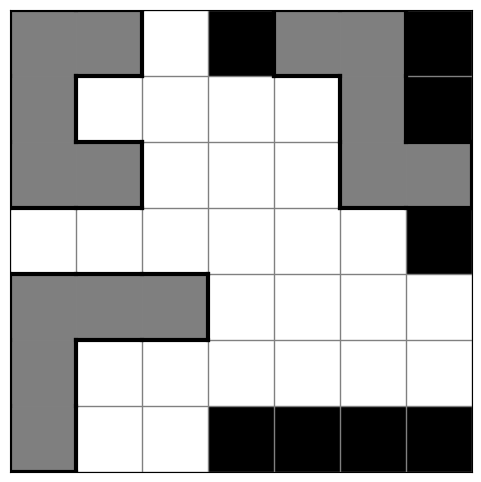

action: 2412
n pieces remaining: 6
action space size: 167
correct move


In [541]:
# deterministic doesn't seem to matter too much
evaluate(model, pieces_remaining, deterministic=False)

In [542]:
# Test on April 14 (trained date)
print("April 14 (trained):")
win_rate_414 = evaluate_win_rate(model, 4, 14, n_episodes=1000)
print(f"Win rate: {win_rate_414:.1%}\n")

April 14 (trained):
Win rate: 95.7%



# Level 7

## Train

In [544]:
n_envs = 6
pieces_remaining = 7

env = SubprocVecEnv(
    [
        lambda: make_curriculum_env(pieces_remaining=pieces_remaining, replay_prob=0.2)
        for _ in range(n_envs)
    ]
)

model = MaskablePPO.load("curriculum_model_lvl6")
model.learning_rate = 5e-4
model.set_env(env)

model.learn(
    total_timesteps=1_500_000,
    reset_num_timesteps=False,
    callback=[TimerCallback(), GradNormCallback()],
)

model.save(f"curriculum_model_lvl{pieces_remaining}")

Logging to ./curriculum_ppo_logs_manual/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.76     |
| time/              |          |
|    fps             | 699      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2807808  |
| train/             |          |
|    grad_norm       | 0        |
---------------------------------
Step 2808000, 3s elapsed, 2s remaining
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1          |
|    ep_rew_mean          | 0.85       |
| time/                   |            |
|    fps                  | 625        |
|    iterations           | 2          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2809344    |
| train/                  |            |
|    approx_kl            | 0.05890077 |
|    clip_fraction        | 0.0527     |
|    clip_range

## Evaluation

In [545]:
model = MaskablePPO.load("curriculum_model_lvl7")
results = evaluate_curriculum_agent(model, pieces_remaining=pieces_remaining, n_episodes=1000)
print(f"{pieces_remaining} pieces remaining")
print(f"  Agent success:  {results['success_rate']:.1%}")
print(f"  Random baseline: {results['random_baseline']:.1%}")
print(f"  Advantage:      {results['advantage']:+.1%}")

7 pieces remaining
  Agent success:  80.3%
  Random baseline: 1.2%
  Advantage:      +79.1%


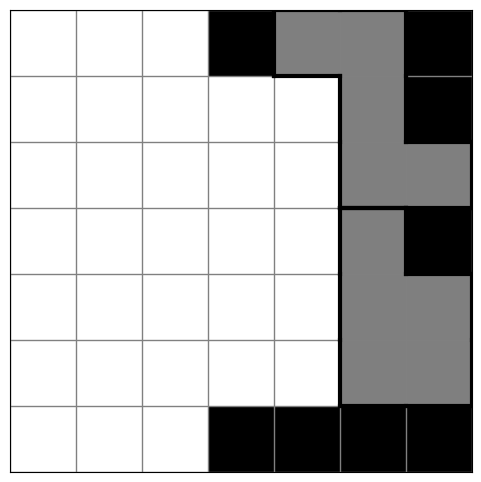

action: 2412
n pieces remaining: 7
action space size: 452
correct move


In [572]:
# deterministic doesn't seem to matter too much
evaluate(model, pieces_remaining, deterministic=False)

In [552]:
# Test on April 14 (trained date)
print("April 14 (trained):")
win_rate_414 = evaluate_win_rate(model, 4, 14, n_episodes=1000)
print(f"Win rate: {win_rate_414:.1%}\n")

April 14 (trained):
Win rate: 91.3%

